# Import Libraries

In [1]:
# All the imports for training the model
# And Validation

import datetime
import glob
import os
import random
import time
import warnings

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

from mlxtend.plotting import plot_confusion_matrix
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard.writer import SummaryWriter
from tqdm import tqdm

In [2]:
# Import the model and the utility functions
from model import Critic, Generator, init_weights
from utils import gradient_penalty, save_checkpoint, load_checkpoint

In [3]:
plt.ion()   # interactive mode

In [4]:
# Setting manual seed for reproducibility
manual_seed = 999
print(f"Random Seed: {manual_seed}")
torch.manual_seed(manual_seed)

Random Seed: 999


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Pytorch version: {torch.__version__}")
print(f"Device: {device}")

Pytorch version: 1.13.0+cu117
Device: cuda


In [6]:
# Hyperparameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 128
IMAGE_SIZE = 128
CHANNELS_IMG = 3
NUM_CLASSES = 2
GEN_EMBEDDING = 128
IMAGE_SHAPE = (CHANNELS_IMG, IMAGE_SIZE, IMAGE_SIZE)
Z_DIM = 100
NUM_EPOCHS = 1
FEATURES_CRITIC = 32
FEATURES_GEN = 32
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

NGPU = 2

In [7]:
transform = transforms.Compose(
    [
        transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dataset length: 5216
Dataset classes: ['NORMAL', 'PNEUMONIA']
Dataset class to idx mapping: {'NORMAL': 0, 'PNEUMONIA': 1}
Dataset sample: ('../data/chest_xray/train\\NORMAL\\IM-0115-0001.jpeg', 0)


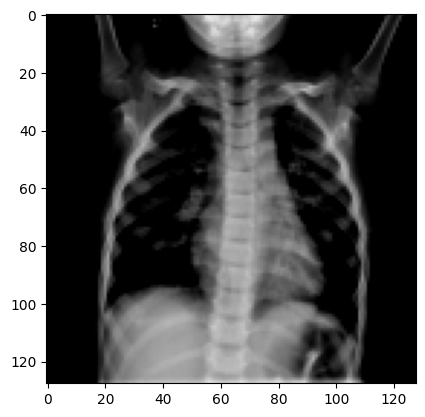

In [8]:
# Load dataset from data/chest_xray/train
dataset = datasets.ImageFolder(root="../data/chest_xray/train", transform=transform)

print(f"Dataset length: {len(dataset)}")
print(f"Dataset classes: {dataset.classes}")
print(f"Dataset class to idx mapping: {dataset.class_to_idx}")

print(f"Dataset sample: {dataset.samples[0]}")

plt.imshow(dataset[0][0].permute(1, 2, 0))
plt.show()

tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])


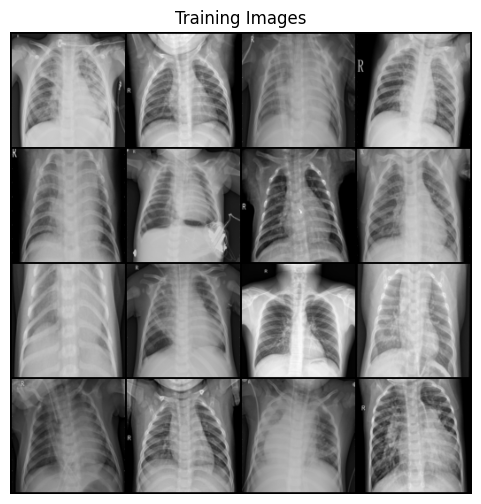

In [9]:
loader = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)

# Print sample batch
real_batch = next(iter(loader))
print(real_batch[1][:16])
plt.figure(figsize=(6, 6))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0].to(device)[:16], 4, padding=2, normalize=True).cpu(),
        (1, 2, 0),
    )
)
plt.show()

In [10]:
generator: Generator = Generator(
    Z_DIM, IMAGE_SHAPE, NUM_CLASSES, GEN_EMBEDDING, FEATURES_GEN, NGPU
).to(device)

if device == "cuda" and NGPU > 1:
    generator = nn.DataParallel(generator, list(range(NGPU)))

init_weights(generator)
print(generator)

Generator(
  (label_embedding): Embedding(2, 128)
  (main): Sequential(
    (0): ConvTranspose2d(228, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): ReLU()
    (14)

In [11]:
critic: Critic = Critic(IMAGE_SHAPE, NUM_CLASSES, FEATURES_CRITIC, NGPU).to(device)

if device == "cuda" and NGPU > 1:
    critic = nn.DataParallel(critic, list(range(NGPU)))

init_weights(critic)
print(critic)

Critic(
  (main): Sequential(
    (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): InstanceNorm2d(512, eps=1e

In [12]:
# Optimizer for generator
opt_gen = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
print(opt_gen)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.0, 0.9)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


In [13]:
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
print(opt_critic)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.0, 0.9)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


In [14]:
# Tensorboard
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")

torch.Size([1, 100, 1, 1]) torch.Size([1])


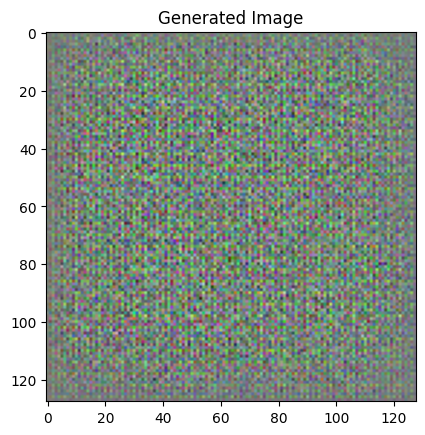

In [15]:
fixed_noise = torch.randn(1, Z_DIM, 1, 1).to(device)
fixed_labels = torch.randint(0, NUM_CLASSES, (1,)).to(device)

print(fixed_noise.shape, fixed_labels.shape)

plt.imshow(
    np.transpose(
        vutils.make_grid(
            generator(fixed_noise, fixed_labels).detach().cpu()[:1], padding=2, normalize=True
        ),
        (1, 2, 0),
    )
)
plt.title("Generated Image")
plt.show()

In [16]:
step = 0
generator_losses = []
critic_losses = []

In [17]:
generator.train()

Generator(
  (label_embedding): Embedding(2, 128)
  (main): Sequential(
    (0): ConvTranspose2d(228, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): ReLU()
    (14)

In [18]:
critic.train()

Critic(
  (main): Sequential(
    (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): InstanceNorm2d(512, eps=1e

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch: 0, Batch: 0
Epoch [0/1] Batch 0/41                       Loss D: -7.1613, loss G: 4.6514


  2%|▏         | 1/41 [00:15<10:01, 15.04s/it]

Epoch: 0, Batch: 1


  5%|▍         | 2/41 [00:18<05:17,  8.14s/it]

Epoch: 0, Batch: 2


  7%|▋         | 3/41 [00:21<03:45,  5.92s/it]

Epoch: 0, Batch: 3


 10%|▉         | 4/41 [00:24<03:00,  4.89s/it]

Epoch: 0, Batch: 4


 12%|█▏        | 5/41 [00:28<02:35,  4.33s/it]

Epoch: 0, Batch: 5


 15%|█▍        | 6/41 [00:31<02:19,  3.97s/it]

Epoch: 0, Batch: 6


 17%|█▋        | 7/41 [00:34<02:07,  3.76s/it]

Epoch: 0, Batch: 7


 20%|█▉        | 8/41 [00:38<01:59,  3.63s/it]

Epoch: 0, Batch: 8


 22%|██▏       | 9/41 [00:41<01:53,  3.54s/it]

Epoch: 0, Batch: 9


 24%|██▍       | 10/41 [00:44<01:47,  3.48s/it]

Epoch: 0, Batch: 10


 27%|██▋       | 11/41 [00:48<01:43,  3.45s/it]

Epoch: 0, Batch: 11


 29%|██▉       | 12/41 [00:51<01:40,  3.47s/it]

Epoch: 0, Batch: 12


 32%|███▏      | 13/41 [00:55<01:40,  3.57s/it]

Epoch: 0, Batch: 13


 34%|███▍      | 14/41 [00:59<01:39,  3.69s/it]

Epoch: 0, Batch: 14


 37%|███▋      | 15/41 [01:03<01:38,  3.78s/it]

Epoch: 0, Batch: 15


 39%|███▉      | 16/41 [01:07<01:36,  3.85s/it]

Epoch: 0, Batch: 16


 41%|████▏     | 17/41 [01:11<01:33,  3.89s/it]

Epoch: 0, Batch: 17


 44%|████▍     | 18/41 [01:15<01:29,  3.91s/it]

Epoch: 0, Batch: 18


 46%|████▋     | 19/41 [01:19<01:26,  3.93s/it]

Epoch: 0, Batch: 19


 49%|████▉     | 20/41 [01:23<01:22,  3.94s/it]

Epoch: 0, Batch: 20


 51%|█████     | 21/41 [01:27<01:19,  3.99s/it]

Epoch: 0, Batch: 21


 54%|█████▎    | 22/41 [01:31<01:16,  4.01s/it]

Epoch: 0, Batch: 22


 56%|█████▌    | 23/41 [01:35<01:11,  4.00s/it]

Epoch: 0, Batch: 23


 59%|█████▊    | 24/41 [01:39<01:07,  3.99s/it]

Epoch: 0, Batch: 24


 61%|██████    | 25/41 [01:43<01:03,  3.99s/it]

Epoch: 0, Batch: 25


 63%|██████▎   | 26/41 [01:47<01:00,  4.03s/it]

Epoch: 0, Batch: 26


 66%|██████▌   | 27/41 [01:51<00:56,  4.04s/it]

Epoch: 0, Batch: 27


 68%|██████▊   | 28/41 [01:56<00:53,  4.10s/it]

Epoch: 0, Batch: 28


 71%|███████   | 29/41 [02:00<00:50,  4.18s/it]

Epoch: 0, Batch: 29


 73%|███████▎  | 30/41 [02:05<00:48,  4.40s/it]

Epoch: 0, Batch: 30


 76%|███████▌  | 31/41 [02:10<00:45,  4.58s/it]

Epoch: 0, Batch: 31


 78%|███████▊  | 32/41 [02:14<00:41,  4.58s/it]

Epoch: 0, Batch: 32


 80%|████████  | 33/41 [02:19<00:36,  4.60s/it]

Epoch: 0, Batch: 33


 83%|████████▎ | 34/41 [02:24<00:33,  4.85s/it]

Epoch: 0, Batch: 34


 85%|████████▌ | 35/41 [02:30<00:29,  4.93s/it]

Epoch: 0, Batch: 35


 88%|████████▊ | 36/41 [02:35<00:24,  4.97s/it]

Epoch: 0, Batch: 36


 90%|█████████ | 37/41 [02:40<00:20,  5.11s/it]

Epoch: 0, Batch: 37


 93%|█████████▎| 38/41 [02:46<00:16,  5.35s/it]

Epoch: 0, Batch: 38


 95%|█████████▌| 39/41 [02:52<00:11,  5.50s/it]

Epoch: 0, Batch: 39


 98%|█████████▊| 40/41 [02:58<00:05,  5.61s/it]

Epoch: 0, Batch: 40


100%|██████████| 41/41 [03:03<00:00,  4.47s/it]


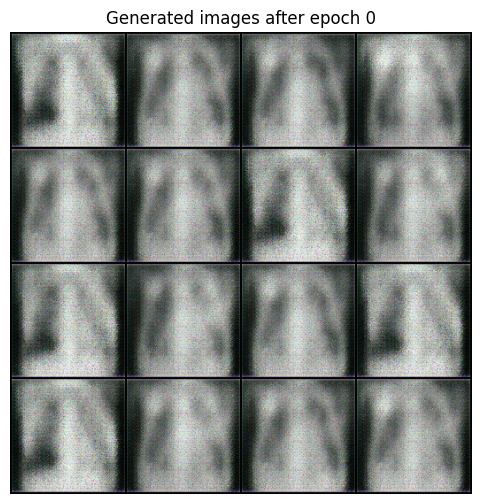

In [19]:
%matplotlib inline
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, labels) in enumerate(tqdm(loader)):
        print(f"Epoch: {epoch}, Batch: {batch_idx}")
        real = real.to(device)
        cur_batch_size = real.shape[0]
        labels = labels.to(device)

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # => min -E[critic(real)] + E[critic(fake)]
        critic_loss = 0
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = generator(noise, labels)

            critic_real = critic(real, labels).reshape(-1)
            critic_fake = critic(fake, labels).reshape(-1)

            gp = gradient_penalty(critic, labels, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            critic_loss += loss_critic.item() if batch_idx in (0, len(loader)) else 0
        

        # Train Generator: min -E[critic(gen_fake)] <-> max E[critic(gen_fake)]
        gen_fake = critic(fake, labels).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        generator.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx in (0, len(loader)):
            critic_losses.append(critic_loss / CRITIC_ITERATIONS)
            generator_losses.append(loss_gen.item())

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = generator(noise, labels)
                # take out (up to) 32 examples
                img_grid_real = vutils.make_grid(
                    real[:32], normalize=True, padding=2
                )
                img_grid_fake = vutils.make_grid(
                    fake[:32], normalize=True, padding=2
                )

                writer_real.add_image(
                    "Real images", img_grid_real, global_step=step
                )
                writer_fake.add_image("Fake images", img_grid_fake, global_step=step)

            step += 1
    
    # Print images after each epoch
    if epoch % 10 == 0:
        with torch.no_grad():
            sample_noise = torch.randn(16, Z_DIM, 1, 1).to(device)
            sample_labels = torch.randint(0, NUM_CLASSES, (16,)).to(device)
            sample = generator(sample_noise, sample_labels)
            plt.figure(figsize=(6, 6))
            plt.axis("off")
            plt.title(f"Generated images after epoch {epoch}")
            plt.imshow(
                np.transpose(
                    vutils.make_grid(sample[:16], 4, padding=2, normalize=True).cpu(),
                    (1, 2, 0),
                )
            )
            plt.show()
        
        # Save model after each epoch
        torch.save(generator.state_dict(), f"model_states/generator_epoch_{epoch}.pth")
        torch.save(critic.state_dict(), f"model_states/critic_epoch_{epoch}.pth")


# Save model after training
torch.save(generator.state_dict(), "generator.pth")
torch.save(critic.state_dict(), "critic.pth")

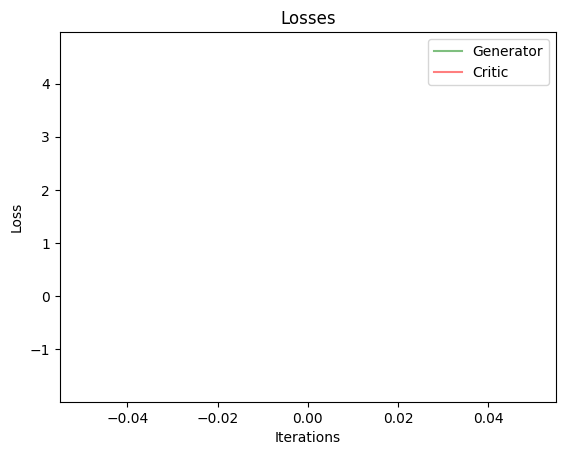

In [20]:
# Plot losses
plt.plot(generator_losses, label="Generator", alpha=0.5, color="green")
plt.plot(critic_losses, label="Critic", alpha=0.5, color="red")
plt.title("Losses")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

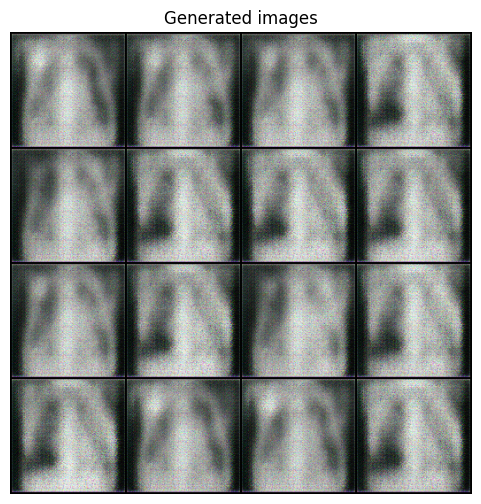

In [21]:
# Plot some images
with torch.no_grad():
    sample_noise = torch.randn(16, Z_DIM, 1, 1).to(device)
    sample_labels = torch.randint(0, NUM_CLASSES, (16,)).to(device)
    sample = generator(sample_noise, sample_labels)
    plt.figure(figsize=(6, 6))
    plt.axis("off")
    plt.title("Generated images")
    plt.imshow(
        np.transpose(
            vutils.make_grid(sample[:16], 4, padding=2, normalize=True).cpu(),
            (1, 2, 0),
        )
    )
    plt.show()